## ECE 324 Project

Author: Zihuan Jiang, Shenxiaozhu Xu, Lucia Sun





## **import libraries and data**


In [ ]:
# import relevent libraries to initialize
import os
import numpy as np
from google.colab import drive
import torch
from torchsummary import summary
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import datetime
from matplotlib.pyplot import imsave
import random

In [ ]:
# load the dataset from google drive
drive.mount('/content/drive',force_remount=True)
!unzip -q '/content/drive/MyDrive/FFHQ2.zip'

Mounted at /content/drive


## **Setup**

### Image setup

In [ ]:
# Good face are the original 1024 * 1024 sized human-face images
GOOD_FACE = ImageFolder(root=os.path.join('FFHQ2'))
# Bad face will be guassian blured and resized to 512 * 512
BAD_FACE = ImageFolder(root=os.path.join('FFHQ2'))

In [ ]:
# split the entire data set to (training_set, validation_set, test_set) = (50%, 20%, 30%)
test_pct = 0.3
test_size = int(len(BAD_FACE)*test_pct)
dataset_size = len(BAD_FACE) - test_size

val_pct = 0.2
val_size = int(len(BAD_FACE)*val_pct)
train_size = dataset_size - val_size
train_ds, val_ds, test_ds = random_split(BAD_FACE, [train_size, val_size, test_size])

In [ ]:
# create a class the Dataset
class FACE(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform  # transform to tensor, including relevant bluring and resize

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label      # label is useless for our model, but keep for potential usage

In [ ]:
# Input data pre-processing
# training transform for low-resolution images
train_transform = transforms.Compose([
    transforms.GaussianBlur((7,7), sigma=5),  # guassian blur
    transforms.Resize((512,512)),             # resize
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # RGB coding normalization
])

# validation transform for low-resolution images
val_transform = transforms.Compose([
    transforms.GaussianBlur((7,7), sigma=5),  # guassian blur
    transforms.Resize((512,512)),             # resize
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # RGB coding normalization
])

# testing transform for low-resolution images
test_transform = transforms.Compose([
    transforms.GaussianBlur((7,7), sigma=5),  # guassian blur
    transforms.Resize((512,512)),             # resize
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # RGB coding normalization
])

# transform for high-resolution images, no guassian blur
good_transform = transforms.Compose([
    transforms.Resize((1024,1024)),           # assert the size of the input
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) # RGB coding normalization
])

In [ ]:
# Input data tranform
# low-resolution input
train_dataset = FACE(ds=train_ds, transform=train_transform)
val_dataset = FACE(ds=val_ds, transform=val_transform)
test_dataset = FACE(ds=test_ds, transform=test_transform)

# high-resolution input
good_dataset = FACE(ds= train_ds,transform = good_transform)
real_val_dataset = FACE(ds=val_ds, transform=good_transform)
real_test_dataset = FACE(ds=test_ds, transform=good_transform)


# Send input data to DataLoader
batch_size = 24
# low-resolution input
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

# high-resolution input
good_dl = DataLoader(good_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
real_val_dl = DataLoader(real_val_dataset, batch_size, num_workers=1, pin_memory=True)
real_test_dl = DataLoader(real_test_dataset, batch_size, num_workers=1, pin_memory=True)

### Device setup

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

# getting default device
device = get_default_device()

In [ ]:
# Moving all DataLoader onto GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
good_dl = DeviceDataLoader(good_dl, device)
real_val_dl = DeviceDataLoader(real_val_dl, device)
real_test_dl = DeviceDataLoader(real_test_dl, device)

### Model setup

In [ ]:
class Generator(nn.Module): #'/content/drive/My Drive/MyModelCheckpoints_19'
    def __init__(self, input_channels=3, output_channels=3):
        super(Generator, self).__init__()
        # CNN layer which maintain the size of the image (1x), downsample the image by 2 (half))
        self.Conv2d_layer_half = nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0)
        self.Conv2d_layer_1x_1 = nn.Conv2d(64, 96, kernel_size = 3, stride = 1, padding = 1)
        self.Conv2d_layer_1x_2 = nn.Conv2d(96, 128, kernel_size = 3, stride = 1, padding = 1)
        self.Conv2d_layer_1x_3 = nn.Conv2d(128, 96, kernel_size = 3, stride = 1, padding = 1)
        self.Conv2d_layer_1x_4 = nn.Conv2d(24, 12, kernel_size = 3, stride = 1, padding = 1)

        self.pixel_shuffle = nn.PixelShuffle(2)

        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()

        # Define bilinear residual layer as an attribute
        self.residual = nn.Upsample(scale_factor=2, mode='bilinear')

        # Initialize the scale factor of the bilinear residual layer
        self.scale_factor_res = torch.nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        residual = self.residual(x)
        x = self.Conv2d_layer_half(x)
        x = self.Tanh(x)
        x = self.Conv2d_layer_1x_1(x)
        x = self.Tanh(x)
        x = self.Conv2d_layer_1x_2(x)
        x = self.Tanh(x)
        x = self.Conv2d_layer_1x_3(x)
        x = self.pixel_shuffle(x)
        x = self.Tanh(x)
        x = self.Conv2d_layer_1x_4(x)
        x = self.pixel_shuffle(x)
        x = self.sigmoid(x)

        scale_factor = torch.clamp(self.scale_factor_res, min=0.2 ,max=0.8)
        x = scale_factor * residual + (1 - scale_factor) * x

        return x

generator = Generator()
to_device(generator, device)

Generator(
  (Conv2d_layer_half): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
  (Conv2d_layer_1x_1): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_3): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_4): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
  (sigmoid): Sigmoid()
  (Tanh): Tanh()
  (residual): Upsample(scale_factor=2.0, mode='bilinear')
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 3*4, bn=False),
            *discriminator_block(3*4, 3*16),
            *discriminator_block(3*16, 3*24),
            *discriminator_block(3*24, 3*16),
            *discriminator_block(3*16, 3*4),
            *discriminator_block(3*4, 3),
        )

        self.adv_layer = nn.Sequential(nn.Linear(768, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)  # Flatten the output for the fully connected layers
        validity = self.adv_layer(out)
        return validity

discriminator = Discriminator()
to_device(discriminator, device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(12, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(48, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(72, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(72, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(48, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(

In [ ]:
# summary of all the parameters of the generator
summary(generator, input_size = (3, 512, 512), batch_size = 24)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1        [24, 3, 1024, 1024]               0
            Conv2d-2         [24, 64, 256, 256]             832
              Tanh-3         [24, 64, 256, 256]               0
            Conv2d-4         [24, 96, 256, 256]          55,392
              Tanh-5         [24, 96, 256, 256]               0
            Conv2d-6        [24, 128, 256, 256]         110,720
              Tanh-7        [24, 128, 256, 256]               0
            Conv2d-8         [24, 96, 256, 256]         110,688
      PixelShuffle-9         [24, 24, 512, 512]               0
             Tanh-10         [24, 24, 512, 512]               0
           Conv2d-11         [24, 12, 512, 512]           2,604
     PixelShuffle-12        [24, 3, 1024, 1024]               0
          Sigmoid-13        [24, 3, 1024, 1024]               0
Total params: 280,236
Trainable params:

In [ ]:
# summary of all the parameters of the discriminator
summary(discriminator, input_size = (3, 1024, 1024), batch_size = 24)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [24, 12, 512, 512]             336
         LeakyReLU-2         [24, 12, 512, 512]               0
         Dropout2d-3         [24, 12, 512, 512]               0
            Conv2d-4         [24, 48, 256, 256]           5,232
         LeakyReLU-5         [24, 48, 256, 256]               0
         Dropout2d-6         [24, 48, 256, 256]               0
       BatchNorm2d-7         [24, 48, 256, 256]              96
            Conv2d-8         [24, 72, 128, 128]          31,176
         LeakyReLU-9         [24, 72, 128, 128]               0
        Dropout2d-10         [24, 72, 128, 128]               0
      BatchNorm2d-11         [24, 72, 128, 128]             144
           Conv2d-12           [24, 48, 64, 64]          31,152
        LeakyReLU-13           [24, 48, 64, 64]               0
        Dropout2d-14           [24, 48,

## **Training**

### PCNR calculation setup

In [ ]:
# Convert images for calculating PSNR
def convert_image(image_tensor):
    image = image_tensor.cpu()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

In [ ]:
# Peak Signal to Noise Ratio (PSNR)
def PSNR(real_image,fake_image):
    MSE = np.mean((real_image.flatten() - fake_image.flatten()) ** 2)
    PSNR = 20 * np.log10(1) - 10 * np.log10(MSE)
    return PSNR

### Saving the model

In [ ]:
# save the model
save_path = '/content/drive/My Drive/MyModelCheckpoints_19'
os.makedirs(save_path, exist_ok=True)  # Creates the directory if it doesn't exist

### Training epoch 0-29

In [ ]:
# Setting up the loss function and the optimizer
criterion = nn.BCELoss()
D_opt = torch.optim.SGD(discriminator.parameters(), lr=0.02, momentum=0.9)
G_opt = torch.optim.SGD(generator.parameters(), lr=0.02, momentum=0.9)

In [ ]:
# first 30 epochs
max_epoch = 30

# initialize validation psnr list
validation_psnr = []

for epoch in range(max_epoch):
    # Iterate over both low-resolution images and high resolution real images simultaneously
    for (low_res_images,_), (real_images,_) in zip(train_dl, good_dl):
        current_batch_size = low_res_images.size(0)

        # Move all the images to the GPU
        low_res_images = low_res_images.to(device)
        real_images = real_images.to(device)

        # Labeling two kinds of the input images for loss calculation
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Compute loss for misclassified-real images (real images calssified as fake)
        discriminator.zero_grad()
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)

        # Compute loss for misclassified-fake images (fake images calssified as real)
        high_res_fake = generator(low_res_images)
        outputs_fake = discriminator(high_res_fake.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Compute total loss and train discriminator
        D_loss = loss_real + loss_fake
        D_loss.backward()
        D_opt.step()

        # Labeling images that is classified as fake by the discriminator, train generator
        generator.zero_grad()
        outputs = discriminator(high_res_fake)
        G_loss = criterion(outputs, real_labels)
        G_loss.backward()
        G_opt.step()

    # complete an epoch, evaluation on validation set
    generator.eval()

    # Fetch a batch of low-resolution images
    dataiter = iter(val_dl)
    low_res_images, _ = next(dataiter)

    # Fetch a batch of high-resolution real images
    dataiter2 = iter(real_val_dl)
    real_images, _ = next(dataiter2)

    # While evaluation, we don't want the model parameter to be altered
    with torch.no_grad():
        high_res_fake = generator(low_res_images.to(device)).cpu()

    # Initialize total psnr values
    psnr_values = []

    # Iteration through a batch of images, compute psnr for each pair
    for real_image, fake_image in zip(real_images, high_res_fake):
        psnr = PSNR(convert_image(real_image), convert_image(fake_image))
        psnr_values.append(psnr)

    # Compute average psnr and storing the mean value
    average_psnr = np.mean(psnr_values)
    validation_psnr.append(average_psnr)

    print(f'epoch complete: {epoch}',"   Average PSNR:", average_psnr)

    # Turn back the model to training
    generator.train()

    # Store the model parameter for each epoch
    torch.save({
        'epoch': epoch,
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'optimizer_d_state_dict': D_opt.state_dict(),
        'optimizer_g_state_dict': G_opt.state_dict(),
    }, os.path.join(save_path, f'checkpoint_epoch_{epoch}.pth'))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch complete: 0    Average PSNR: 16.664787888992972
epoch complete: 1    Average PSNR: 16.668106744980065
epoch complete: 2    Average PSNR: 16.699701608280208
epoch complete: 3    Average PSNR: 16.82194181087917
epoch complete: 4    Average PSNR: 17.27919796128528
epoch complete: 5    Average PSNR: 19.50123900686153
epoch complete: 6    Average PSNR: 23.665693815194278
epoch complete: 7    Average PSNR: 23.67330745220646
epoch complete: 8    Average PSNR: 23.682216761365634
epoch complete: 9    Average PSNR: 23.697996238716883
epoch complete: 10    Average PSNR: 23.743096149206647
epoch complete: 11    Average PSNR: 23.844164350266084
epoch complete: 12    Average PSNR: 23.938112250392596
epoch complete: 13    Average PSNR: 23.959604550686223
epoch complete: 14    Average PSNR: 23.97516999772837
epoch complete: 15    Average PSNR: 24.010422984086162
epoch complete: 16    Average PSNR: 24.04565700219767
epoch complete: 17    Average PSNR: 24.062690826532442
epoch complete: 18    Aver

### Training epoch 30-59

In [ ]:
# Setting up the loss function and the optimizer
criterion = nn.BCELoss()
D_opt = torch.optim.SGD(discriminator.parameters(), lr=0.02, momentum=0.9)
G_opt = torch.optim.SGD(generator.parameters(), lr=0.02, momentum=0.9)

In [ ]:
max_epoch = 30

for epoch in range(max_epoch):
    # Iterate over both low-resolution images and high resolution real images simultaneously
    for (low_res_images,_), (real_images,_) in zip(train_dl, good_dl):
        current_batch_size = low_res_images.size(0)

        # Move all the images to the GPU
        low_res_images = low_res_images.to(device)
        real_images = real_images.to(device)

        # Labeling two kinds of the input images for loss calculation
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Compute loss for misclassified-real images (real images calssified as fake)
        discriminator.zero_grad()
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)

        # Compute loss for misclassified-fake images (fake images calssified as real)
        high_res_fake = generator(low_res_images)
        outputs_fake = discriminator(high_res_fake.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Compute total loss and train discriminator
        D_loss = loss_real + loss_fake
        D_loss.backward()
        D_opt.step()

        # Labeling images that is classified as fake by the discriminator, train generator
        generator.zero_grad()
        outputs = discriminator(high_res_fake)
        G_loss = criterion(outputs, real_labels)
        G_loss.backward()
        G_opt.step()

    # complete an epoch, evaluation on validation set
    generator.eval()

    # Fetch a batch of low-resolution images
    dataiter = iter(val_dl)
    low_res_images, _ = next(dataiter)

    # Fetch a batch of high-resolution real images
    dataiter2 = iter(real_val_dl)
    real_images, _ = next(dataiter2)

    # While evaluation, we don't want the model parameter to be altered
    with torch.no_grad():
        high_res_fake = generator(low_res_images.to(device)).cpu()

    # Initialize total psnr values
    psnr_values = []

    # Iteration through a batch of images, compute psnr for each pair
    for real_image, fake_image in zip(real_images, high_res_fake):
        psnr = PSNR(convert_image(real_image), convert_image(fake_image))
        psnr_values.append(psnr)

    # Compute average psnr and storing the mean value
    average_psnr = np.mean(psnr_values)
    validation_psnr.append(average_psnr)

    print(f'epoch complete: {epoch+30}',"   Average PSNR:", average_psnr)

    # Turn back the model to training
    generator.train()

    # Store the model parameter for each epoch
    torch.save({
        'epoch': epoch+30,
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'optimizer_d_state_dict': D_opt.state_dict(),
        'optimizer_g_state_dict': G_opt.state_dict(),
    }, os.path.join(save_path, f'checkpoint_epoch_{epoch+30}.pth'))

epoch complete: 30    Average PSNR: 24.753120206385546
epoch complete: 31    Average PSNR: 24.798096705763857
epoch complete: 32    Average PSNR: 24.862131450445432
epoch complete: 33    Average PSNR: 24.902912057363398
epoch complete: 34    Average PSNR: 24.946368903011187
epoch complete: 35    Average PSNR: 25.01805834324477
epoch complete: 36    Average PSNR: 25.09691842054946
epoch complete: 37    Average PSNR: 25.143285220028783
epoch complete: 38    Average PSNR: 25.200610853224948
epoch complete: 39    Average PSNR: 25.248167882692048
epoch complete: 40    Average PSNR: 25.279340056152677
epoch complete: 41    Average PSNR: 25.301617670667948
epoch complete: 42    Average PSNR: 25.30875083778894
epoch complete: 43    Average PSNR: 25.312611087227356
epoch complete: 44    Average PSNR: 25.31605186366994
epoch complete: 45    Average PSNR: 25.318086530128806
epoch complete: 46    Average PSNR: 25.3195534516848
epoch complete: 47    Average PSNR: 25.320201524196012
epoch complete: 

### Training epoch 60-79

In [ ]:
# Setting up the loss function and the optimizer
criterion = nn.BCELoss()
D_opt = torch.optim.SGD(discriminator.parameters(), lr=0.005, momentum=0.9)
G_opt = torch.optim.SGD(generator.parameters(), lr=0.005, momentum=0.9)

In [ ]:
max_epoch = 20

for epoch in range(max_epoch):
    # Iterate over both low-resolution images and high resolution real images simultaneously
    for (low_res_images,_), (real_images,_) in zip(train_dl, good_dl):
        current_batch_size = low_res_images.size(0)

        # Move all the images to the GPU
        low_res_images = low_res_images.to(device)
        real_images = real_images.to(device)

        # Labeling two kinds of the input images for loss calculation
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Compute loss for misclassified-real images (real images calssified as fake)
        discriminator.zero_grad()
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)

        # Compute loss for misclassified-fake images (fake images calssified as real)
        high_res_fake = generator(low_res_images)
        outputs_fake = discriminator(high_res_fake.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Compute total loss and train discriminator
        D_loss = loss_real + loss_fake
        D_loss.backward()
        D_opt.step()

        # Labeling images that is classified as fake by the discriminator, train generator
        generator.zero_grad()
        outputs = discriminator(high_res_fake)
        G_loss = criterion(outputs, real_labels)
        G_loss.backward()
        G_opt.step()

    # complete an epoch, evaluation on validation set
    generator.eval()

    # Fetch a batch of low-resolution images
    dataiter = iter(val_dl)
    low_res_images, _ = next(dataiter)

    # Fetch a batch of high-resolution real images
    dataiter2 = iter(real_val_dl)
    real_images, _ = next(dataiter2)

    # While evaluation, we don't want the model parameter to be altered
    with torch.no_grad():
        high_res_fake = generator(low_res_images.to(device)).cpu()

    # Initialize total psnr values
    psnr_values = []

    # Iteration through a batch of images, compute psnr for each pair
    for real_image, fake_image in zip(real_images, high_res_fake):
        psnr = PSNR(convert_image(real_image), convert_image(fake_image))
        psnr_values.append(psnr)

    # Compute average psnr and storing the mean value
    average_psnr = np.mean(psnr_values)
    validation_psnr.append(average_psnr)

    print(f'epoch complete: {epoch+60}',"   Average PSNR:", average_psnr)

    # Turn back the model to training
    generator.train()

    # Store the model parameter for each epoch
    torch.save({
        'epoch': epoch+60,
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'optimizer_d_state_dict': D_opt.state_dict(),
        'optimizer_g_state_dict': G_opt.state_dict(),
    }, os.path.join(save_path, f'checkpoint_epoch_{epoch+60}.pth'))

epoch complete: 60    Average PSNR: 25.297962813212113
epoch complete: 61    Average PSNR: 25.29792325013914
epoch complete: 62    Average PSNR: 25.297867739760875
epoch complete: 63    Average PSNR: 25.297820126007412
epoch complete: 64    Average PSNR: 25.297776657394184
epoch complete: 65    Average PSNR: 25.297703525317218
epoch complete: 66    Average PSNR: 25.297601934182836
epoch complete: 67    Average PSNR: 25.297505308789216
epoch complete: 68    Average PSNR: 25.297418778542056
epoch complete: 69    Average PSNR: 25.297325388841415
epoch complete: 70    Average PSNR: 25.297223083105678
epoch complete: 71    Average PSNR: 25.29712233266184
epoch complete: 72    Average PSNR: 25.296992580689572
epoch complete: 73    Average PSNR: 25.296867797544717
epoch complete: 74    Average PSNR: 25.296717803016236
epoch complete: 75    Average PSNR: 25.296513732460838
epoch complete: 76    Average PSNR: 25.296270972986054
epoch complete: 77    Average PSNR: 25.2961052230676
epoch complete

## **Evaluation**

### Show the validaton PSNR curve with respect to epoch

#### Validation PSNR list within the current runtime

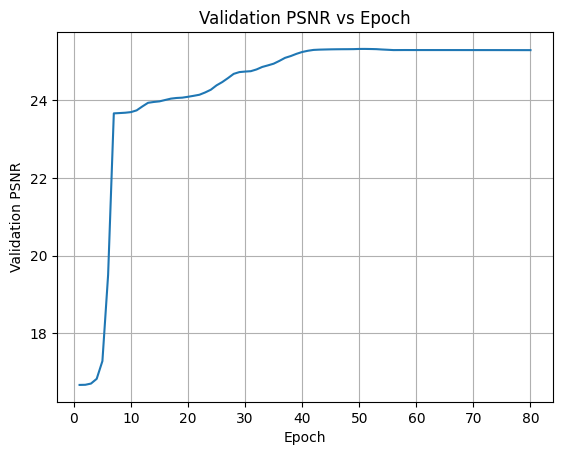

Mounted at /content/drive


In [ ]:
# Create x-axis values representing the number of total epoch
x_values = range(1, len(validation_psnr) + 1)

# Plotting
plt.plot(x_values, validation_psnr, linestyle='-')
plt.title('Validation PSNR vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation PSNR')
plt.grid(True)
plt.show()

# Save the validation_psnr array to Google Drive
drive.mount('/content/drive',force_remount=True)
np.save('/content/drive/My Drive/validation_psnr19.npy', validation_psnr)

#### Validation PSNR list is stored

In [ ]:
# Load the validation_psnr array from the downloaded file
validation_psnr = np.load('/content/drive/My Drive/validation_psnr19.npy')

# Plotting
plt.plot(validation_psnr, linestyle='-')
plt.title('Validation PSNR vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation PSNR')
plt.grid(True)
plt.show()

### Load model parameter at the desired epoch

In [ ]:
save_path = '/content/drive/My Drive/MyModelCheckpoints_19'
checkpoint_path = os.path.join(save_path, 'checkpoint_epoch_50.pth')

# Load the model
checkpoint = torch.load(checkpoint_path)
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
state_dict = checkpoint['generator_state_dict']

# Some keys are no longer used in the generator
keys_to_ignore = [
    "Conv2d_layer_half2.weight",
    "Conv2d_layer_half2.bias",
    "bn3.weight",
    "bn3.bias",
    "bn3.running_mean",
    "bn3.running_var",
    "bn3.num_batches_tracked",
    "bn12.weight",
    "bn12.bias",
    "bn12.running_mean",
    "bn12.running_var",
    "bn12.num_batches_tracked",
    "bn64.weight",
    "bn64.bias",
    "bn64.running_mean",
    "bn64.running_var",
    "bn64.num_batches_tracked",
    "bn128.weight",
    "bn128.bias",
    "bn128.running_mean",
    "bn128.running_var",
    "bn128.num_batches_tracked"
]

# Filter out the keys to ignore
filtered_state_dict = {k: v for k, v in state_dict.items() if k not in keys_to_ignore}

In [ ]:
D_opt.load_state_dict(checkpoint['optimizer_d_state_dict'])
G_opt.load_state_dict(checkpoint['optimizer_g_state_dict'])

# Retrieve the epoch
epoch = checkpoint['epoch']

### Model evaluation on test set

In [ ]:
# Make sure the generator is in evaluation mode
generator.eval()

# Fetch a batch of low-resolution images
dataiter = iter(test_dl)
low_res_images, _ = next(dataiter)

# Fetch a batch of high-resolution real images
dataiter2 = iter(real_test_dl)
real_images, _ = next(dataiter2)

# While evaluation, we don't want the model parameter to be altered
with torch.no_grad():
    high_res_fake = generator(low_res_images.to(device)).cpu()

# Initialize total psnr values
psnr_values = []

# Iteration through a batch of images, compute psnr for each pair
for real_image, fake_image in zip(real_images, high_res_fake):
    psnr = PSNR(convert_image(real_image), convert_image(fake_image))
    psnr_values.append(psnr)

# Print average PSNR value
average_psnr = np.mean(psnr_values)
print("Average PSNR on test set:", average_psnr)

# Set the generator back to training mode
generator.train()

Average PSNR on test set: 25.656627972397093


Generator(
  (Conv2d_layer_half): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
  (Conv2d_layer_1x_1): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_3): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d_layer_1x_4): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
  (sigmoid): Sigmoid()
  (Tanh): Tanh()
  (residual): Upsample(scale_factor=2.0, mode='bilinear')
)

### Sample output

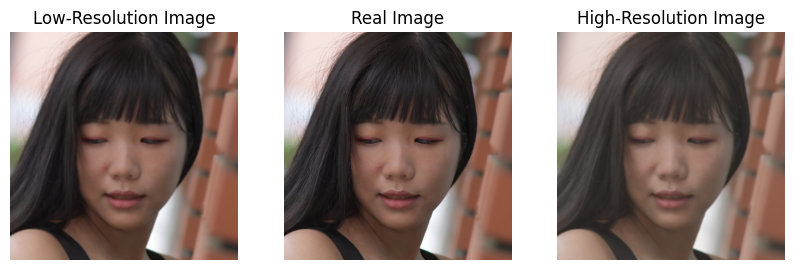

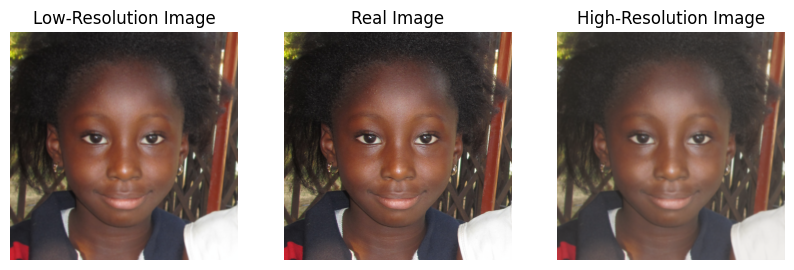

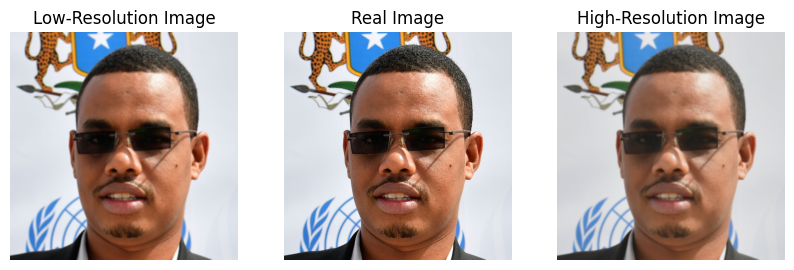

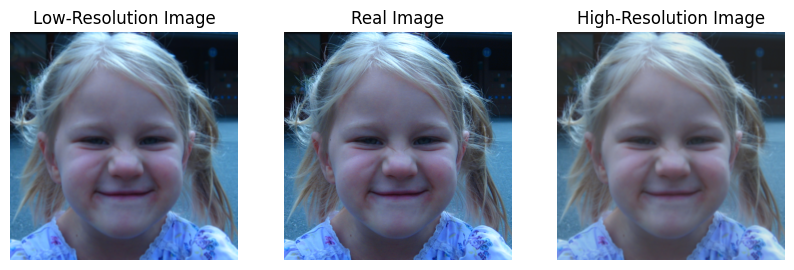

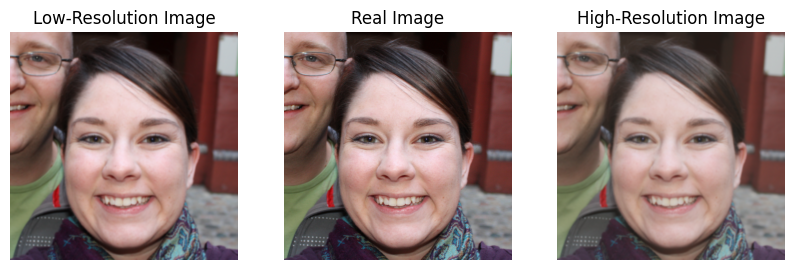

In [ ]:
# Set the number of sets to plot
num_sets = 5

# Randomly select 5 indices from dataset
indices = random.sample(range(len(low_res_images)), num_sets)

# Plotting
for i in range(num_sets):
    low_res_sample = low_res_images[indices[i]]
    real_sample = real_images[indices[i]]

    with torch.no_grad():
        high_res_fake = generator(low_res_sample.unsqueeze(0).to(device)).cpu()

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    # Plot low-resolution image
    axes[0].imshow(convert_image(low_res_sample))
    axes[0].set_title("Low-Resolution Image")
    axes[0].axis('off')

    # Plot real image
    axes[1].imshow(convert_image(real_sample))
    axes[1].set_title("Real Image")
    axes[1].axis('off')

    # Plot high-resolution (super-resolved) image
    axes[2].imshow(convert_image(high_res_fake[0]))
    axes[2].set_title("High-Resolution Image")
    axes[2].axis('off')

    plt.show()